<a href="https://colab.research.google.com/github/jmlDC/MediaBias-Thesis22-23/blob/Trying-Straight-Methods/ScrapingNews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MEDIA BIAS Thesis

# Setting up Environment

### PIP install

In [1]:
!pip3 install requests-html
!apt update
!apt install chromium-chromedriver
!pip3 install selenium
!pip3 install webdriver-manager

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:12 http://ppa.launchpad.net/graphic

In [2]:
# Needed for Selenium
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

cp: '/usr/lib/chromium-browser/chromedriver' and '/usr/bin/chromedriver' are the same file


### Imports

In [3]:
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

In [4]:
import urllib.request,sys,time
from bs4 import BeautifulSoup
import requests
import pandas as pd

from requests_html import HTMLSession 

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By


/usr/local/lib/python3.7/dist-packages/trio/_core/_multierror.py:411: RuntimeWarning: IPython detected, but you already have a custom exception handler installed. I'll skip installing Trio's custom handler, but this means exception groups will not show full tracebacks.
  category=RuntimeWarning,


### Mounting to GDrive

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### dir variable

In [6]:
dir  = "/content/gdrive/MyDrive/THESIS-MS/Truth-Thesis22-23/"

# Scraping

## Politifact

In [7]:
## Politifact 
pagesToGet= 1
upperframe=[]  
site = "politifact"


for page in range(1,pagesToGet+1):
    print('processing page :', page)
    url = 'https://www.politifact.com/factchecks/list/?page='+str(page)
    print(url)
    
    #an exception might be thrown, so the code should be in a try-except block
    try:
        #use the browser to get the url. This is suspicious command that might blow up.
        page=requests.get(url)                             # this might throw an exception if something goes wrong.
    
    except Exception as e:                                   # this describes what to do if an exception is thrown
        error_type, error_obj, error_info = sys.exc_info()      # get the exception information
        print ('ERROR FOR LINK:',url)                          #print the link that cause the problem
        print (error_type, 'Line:', error_info.tb_lineno)     #print error info and line that threw the exception
        continue                                              #ignore this page. Abandon this and go back.

    time.sleep(2)   
    soup=BeautifulSoup(page.text,'html.parser')
    frame=[]
    links=soup.find_all('li',attrs={'class':'o-listicle__item'})
    print(len(links))

    
    filename= f"{dir + site}NEWS.csv"
    f=open(filename,"w", encoding = 'utf-8')
    headers="Statement,Link,Date, Source, Label\n"
    f.write(headers)
    
    for j in links:
        Statement = j.find("div",attrs={'class':'m-statement__quote'}).text.strip()
        Link = "https://www.politifact.com"
        Link += j.find("div",attrs={'class':'m-statement__quote'}).find('a')['href'].strip()
        Date = j.find('div',attrs={'class':'m-statement__body'}).find('footer').text[-14:-1].strip()
        Source = j.find('div', attrs={'class':'m-statement__meta'}).find('a').text.strip()
        Label = j.find('div', attrs ={'class':'m-statement__content'}).find('img',attrs={'class':'c-image__original'}).get('alt').strip()
        frame.append((Statement,Link,Date,Source,Label))
        f.write(Statement.replace(",","^")+","+Link+","+Date.replace(",","^")+","+Source.replace(",","^")+","+Label.replace(",","^")+"\n")
    upperframe.extend(frame)
f.close()
data=pd.DataFrame(upperframe, columns=['Statement','Link','Date','Source','Label'])
data.head()

processing page : 1
https://www.politifact.com/factchecks/list/?page=1
30


,Statement,Link,Date,Source,Label
0,Photo shows “late-night operatives moving van-...,https://www.politifact.com/factchecks/2022/nov...,"mber 10, 2022",Viral image,false
1,The number of followers John Fetterman and Meh...,https://www.politifact.com/factchecks/2022/nov...,"mber 10, 2022",Instagram posts,pants-fire
2,A “dead man on the ballot” is evidence the Dem...,https://www.politifact.com/factchecks/2022/nov...,"mber 10, 2022",Instagram posts,false
3,Graph shows Gretchen Whitmer stole the Michiga...,https://www.politifact.com/factchecks/2022/nov...,"mber 10, 2022",Instagram posts,pants-fire
4,Map proves the Pennsylvania Senate election wa...,https://www.politifact.com/factchecks/2022/nov...,"mber 10, 2022",Instagram posts,pants-fire


## Extract Source Function

In [8]:
def extract_source(url):
    agent = {"User-Agent":"Chrome/105.0.0.0"}
    try:
      source=requests.get(url, headers=agent)
    except Exception as e:                                   # this describes what to do if an exception is thrown
      error_type, error_obj, error_info = sys.exc_info()      # get the exception information
      print ('ERROR FOR LINK:',url)                          #print the link that cause the problem
      print (error_type, 'Line:', error_info.tb_lineno)     #print error info and line that threw the exception
    
    return source                                               #ignore this page. Abandon this and go back.

## Manila Bulletin

In [9]:
## Manila bulletin
pagesToGet= 1
upperframe=[]  
topic = "ukraine war"
site = "manilaBulletin"

data=pd.DataFrame(columns=['Statement','Link','Date',"Topic"])


for page in range(1,pagesToGet+1):
    print('processing page :', page)
    url = 'https://mb.com.ph/page/'+str(page)+'/?s='+topic.replace(" ", "+")
    print(url)

    time.sleep(2)   
    soup=BeautifulSoup(extract_source(url).text, 'html.parser')

    links=soup.find("article", {'class' : 'content-bar col-12 col-lg-12 order-1 col-xl order-xl-2'}).find_all('li',attrs={'class':'article'})
    print(len(links))
    
    filename= f"{dir}{site}-{topic}-NEWS-List.csv"    
    for j in links:
        frame=[]
        try:
          Statement = j.find('h4').find('a').text
          Link = j.find('h4',attrs={'class':'title'}).find('a')['href'].strip()
          Date = j.find('time', {'class': 'time-ago'})['data-time'][0:10].strip()
          frame.extend((Statement, Link, Date, topic))
        except Exception as e:
            pass

        data = data.append(pd.Series(frame, index=data.columns[:len(frame)]), ignore_index=True)
data.to_csv(filename)
data.head()

processing page : 1
https://mb.com.ph/page/1/?s=ukraine+war
16


,Statement,Link,Date,Topic
0,Putin: Russia battling ‘Western domination’ as...,https://mb.com.ph/2022/10/28/putin-russia-batt...,2022-10-28,ukraine war
1,"Pope urges UN reform after Ukraine war, Covid ...",https://mb.com.ph/2022/10/17/pope-urges-un-ref...,2022-10-17,ukraine war
2,"Amid Ukraine war, US flies Russian cosmonaut t...",https://mb.com.ph/2022/10/06/amid-ukraine-war-...,2022-10-06,ukraine war
3,Russia-Ukraine war is ‘a world war’ — Pope Fra...,https://mb.com.ph/2022/09/29/russia-ukraine-wa...,2022-09-29,ukraine war
4,Pope urges end to ‘senseless’ Ukraine war duri...,https://mb.com.ph/2022/09/14/pope-urges-end-to...,2022-09-14,ukraine war


In [10]:
data2 = pd.DataFrame(columns=["Title", "Author", "Date", "Text"])
filename= f"{dir+site+'-'+topic}NEWS.csv"

for index, row in data.iterrows():
  url = row["Link"] 
  print(url)

  time.sleep(1)   
  soup=BeautifulSoup(extract_source(url).text, 'html.parser')

  head=soup.find("article", {'id' : 'the-article-content'})
  # print(content.prettify())
  textList =soup.find("article", {'id' : 'the-article-content'}).find("section", {'class': 'article-content'}).find_all("p")
  
  
  row=[]
  try:
    Title = head.find('h2',{'class':'title'}).text.strip()
    Author = head.find('p',attrs={'class':'author'}).find('a').text[3:].strip()
    Date = head.find('p', attrs={'class': 'published'}).text[10:-9].strip(",") 
  except Exception as e:
      pass
  
  body = ""
  for t in textList:
    body += (t.text.replace('\u200b', '')) +"\n" 

  row.extend((Title, Author, Date, body))
  

  data2 = data2.append(pd.Series(row, index=data2.columns[:len(row)]), ignore_index=True)
  
data2.to_csv(filename)
data2.head()

https://mb.com.ph/2022/10/28/putin-russia-battling-western-domination-as-ukraine-war-grinds-on/
https://mb.com.ph/2022/10/17/pope-urges-un-reform-after-ukraine-war-covid-limits/
https://mb.com.ph/2022/10/06/amid-ukraine-war-us-flies-russian-cosmonaut-to-iss/
https://mb.com.ph/2022/09/29/russia-ukraine-war-is-a-world-war-pope-francis/
https://mb.com.ph/2022/09/14/pope-urges-end-to-senseless-ukraine-war-during-kazakhstan-visit/
https://mb.com.ph/2022/08/04/gatchalian-seeks-impact-assessment-of-russia-ukraine-war-on-ph/
https://mb.com.ph/2022/08/03/us-sanctions-putin-girlfriend-more-oligarchs-for-complicity-in-ukraine-war/
https://mb.com.ph/2022/07/20/pacquiao-yoo-exhibition-match-to-serve-as-charity-event-for-ukraine-war-victims/
https://mb.com.ph/2022/07/15/ukraine-war-to-dominate-g20-finance-chief-meeting-in-indonesia/
https://mb.com.ph/2022/06/27/ukraine-war-could-boost-illegal-drug-production-un/
https://mb.com.ph/2022/06/09/un-chief-warns-impact-of-ukraine-war-on-world-is-worsening/

,Title,Author,Date,Text
0,Putin: Russia battling ‘Western domination’ as...,Agence-France-Presse,"October 28, 2022","MOSCOW, Russia — President Vladimir Putin said..."
1,"Pope urges UN reform after Ukraine war, Covid ...",Agence-France-Presse,"October 17, 2022","VATICAN CITY, Holy See – Pope Francis said the..."
2,"Amid Ukraine war, US flies Russian cosmonaut t...",Agence-France-Presse,"October 6, 2022",UNITED STATES — A SpaceX rocket carrying a Rus...
3,Russia-Ukraine war is ‘a world war’ — Pope Fra...,Philippine News Agency,"September 29, 2022",\n\nVATICAN CITY – Pope Francis said it is a ...
4,Pope urges end to ‘senseless’ Ukraine war duri...,Agence-France-Presse,"September 14, 2022","NUR SULTAN, Kazakhstan – Pope Francis on Tuesd..."


## ABS CBN

In [11]:
## ABS CBN
pagesToGet= 2
topic = "Queen Elizabeth Death"
site = "ABS-CBN_NEWS"


chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
userAgent = "Chrome/105.0.0.0"
chrome_options.add_argument(f"user-agent={userAgent}")
driver = webdriver.Chrome('chromedriver',options=chrome_options)

data=pd.DataFrame(columns=['Title','Link','Date',"Topic"])

for page in range(1,pagesToGet+1):
  url = 'https://news.abs-cbn.com/special-pages/search?q='+topic.replace(" ", "%20")+'&gsc.sort=&gsc.page='+str(page)+'#gsc.tab=0&gsc.q='+topic.replace(" ", "%20")+'&gsc.sort=&gsc.page='+str(page)
  print(url)

  driver.get(url)
  # WebDriverWait(driver, 30).until(EC.visibility_of_element_located((By.ID, '___gcse_0'))) 
  source = driver.page_source

  time.sleep(2)   
  soup = BeautifulSoup(source, 'html.parser')
  searches = soup.find_all('div', {'class':'gsc-webResult gsc-result'})
  filename= f"{dir}{site}-{topic}-NEWS-List.csv"     

  for x in searches:
    frame=[]
    Title = x.find('div', class_="gs-title").find("a").text.strip()
    Date = x.find('div', class_="gs-bidi-start-align gs-snippet").text[:12].strip()
    Link = x.find('a', class_="gs-title")['href']
    frame.extend((Title, Link, Date, topic))

    data = data.append(pd.Series(frame, index=data.columns[:len(frame)]), ignore_index=True)



data.to_csv(filename)
driver.quit()
data





https://news.abs-cbn.com/special-pages/search?q=Queen%20Elizabeth%20Death&gsc.sort=&gsc.page=1#gsc.tab=0&gsc.q=Queen%20Elizabeth%20Death&gsc.sort=&gsc.page=1
https://news.abs-cbn.com/special-pages/search?q=Queen%20Elizabeth%20Death&gsc.sort=&gsc.page=2#gsc.tab=0&gsc.q=Queen%20Elizabeth%20Death&gsc.sort=&gsc.page=2


,Title,Link,Date,Topic
0,Queen Elizabeth II died of 'old age': death ce...,https://news.abs-cbn.com/overseas/09/30/22/que...,"Sep 30, 2022",Queen Elizabeth Death
1,Queen Elizabeth II dies at 96 | ABS-CBN News,https://news.abs-cbn.com/overseas/09/09/22/que...,"Sep 9, 2022",Queen Elizabeth Death
2,The death of Queen Elizabeth II: Thursday's ti...,https://news.abs-cbn.com/overseas/09/09/22/the...,"Sep 9, 2022",Queen Elizabeth Death
3,London Bridge: The protocol after Queen Elizab...,https://news.abs-cbn.com/overseas/09/09/22/lon...,"Sep 9, 2022",Queen Elizabeth Death
4,Queen Elizabeth II: Record-breaking monarch | ...,https://news.abs-cbn.com/spotlight/09/09/22/qu...,"Sep 9, 2022",Queen Elizabeth Death
5,Queen Elizabeth II begins solemn final journey...,https://news.abs-cbn.com/overseas/09/11/22/que...,"Sep 11, 2022",Queen Elizabeth Death
6,Sporting world pays tribute to Queen Elizabeth...,https://news.abs-cbn.com/sports/09/09/22/sport...,"Sep 9, 2022",Queen Elizabeth Death
7,"Hong Kongers mourn Queen Elizabeth, and a bygo...",https://news.abs-cbn.com/video/overseas/09/20/...,"Sep 20, 2022",Queen Elizabeth Death
8,Death of Queen Elizabeth II: What happens next...,https://news.abs-cbn.com/spotlight/09/15/22/de...,"Sep 15, 2022",Queen Elizabeth Death
9,Queen's death spells awkward return for Prince...,https://news.abs-cbn.com/spotlight/09/13/22/qu...,"Sep 13, 2022",Queen Elizabeth Death


In [12]:
data2 = pd.DataFrame(columns=["Title", "Author", "Date", "Text"])
filename= f"{dir+site+'-'+topic}NEWS.csv"

for index, row in data.iterrows():
  url = row["Link"] 
  if ('multimedia/photo' in url):
    pass
  else:
    print(url)

    time.sleep(1)   
    soup=BeautifulSoup(extract_source(url).text, 'html.parser')
      
    row=[]
    
    Title = soup.find('h1',{'class':'news-title'}).text.strip()
    Author = soup.find('span',attrs={'class':'editor'}).text.strip()
    Date = soup.find('span', attrs={'class': 'date-posted'}).text[:-8].strip() 
    
    textList =soup.find("div", {'class' :'article-content'}).find_all("p")
    body = ""
    for t in textList:
      if (t.text != "RELATED VIDEO:"):
        body += (t.text) +"\n" 

    row.extend((Title, Author, Date, body))
    

    data2 = data2.append(pd.Series(row, index=data2.columns[:len(row)]), ignore_index=True)
  
data2.to_csv(filename)
data2.head()

https://news.abs-cbn.com/overseas/09/30/22/queen-elizabeth-ii-died-of-old-age-death-certificate
https://news.abs-cbn.com/overseas/09/09/22/queen-elizabeth-ii-dies-at-96
https://news.abs-cbn.com/overseas/09/09/22/the-death-of-queen-elizabeth-ii-thursdays-timeline
https://news.abs-cbn.com/overseas/09/09/22/london-bridge-the-protocol-after-queen-elizabeths-death
https://news.abs-cbn.com/spotlight/09/09/22/queen-elizabeth-ii-record-breaking-monarch
https://news.abs-cbn.com/overseas/09/11/22/queen-elizabeth-ii-begins-solemn-final-journey
https://news.abs-cbn.com/sports/09/09/22/sporting-world-pays-tribute-to-queen-elizabeth-ii
https://news.abs-cbn.com/video/overseas/09/20/22/hong-kongers-mourn-queen-elizabeth-and-a-bygone-age


AttributeError: ignored

## GMA 

In [13]:
# https://www.gmanetwork.com/news/#/search;query=queen%20elizabeth%20death;sortBy=_score;isDesc=1

topic = "Queen Elizabeth Death"
site = "GMA-Network"


chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument('--disable-blink-features=AutomationControlled')
userAgent = "Chrome/105.0.0.0"
chrome_options.add_argument(f"user-agent={userAgent}")
driver = webdriver.Chrome('chromedriver',options=chrome_options)

data=pd.DataFrame(columns=['Title','Link','Date',"Topic"])

url = 'https://www.gmanetwork.com/news/#/search;query='+topic.replace(" ", "%20")+';sortBy=_score;isDesc=1'
print(url)

driver.get(url)
WebDriverWait(driver, 50).until(EC.visibility_of_element_located((By.CLASS_NAME, 'clearfix'))) 
source = driver.page_source

time.sleep(2)   
soup = BeautifulSoup(source, 'html.parser')
searches = soup.find_all('div', {'class':'zd-row-text-wrap'})
filename= f"{dir}{site}-{topic}-NEWS-List.csv"     
print(len(searches))

for x in searches:
  frame=[]
  Title = x.find('h4', class_="zd-result-title ng-star-inserted").text.strip()
  Date = x.find('div', class_="zd-result-subTitle ng-star-inserted").text[:-18].strip()
  partialTitle = ' '.join(Title.split()[:8])

  try:
    Link = ""
    to_Click = driver.find_element(By.XPATH, f"//*[contains(text(), '{Title}')]")
    print(to_Click.text)
    to_Click.click()
    driver.switch_to.window(driver.window_handles[1])
    Link = driver.current_url
    driver.close()
    driver.switch_to.window(driver.window_handles[0])
  except Exception as e:
    print("Something wrong. Error:", e.split()[0])

  frame.extend((Title, Link, Date, topic))

  data = data.append(pd.Series(frame, index=data.columns[:len(frame)]), ignore_index=True)

data.to_csv(filename)
driver.quit()
data.head(10)


https://www.gmanetwork.com/news/#/search;query=Queen%20Elizabeth%20Death;sortBy=_score;isDesc=1


KeyboardInterrupt: ignored

In [ ]:
data

In [ ]:
data2 = pd.DataFrame(columns=["Title", "Author", "Date", "Text"])
filename= f"{dir+site+'-'+topic}NEWS.csv"

for index, row in data.iterrows():
  url = row["Link"] 
  if (url == ""):
    continue
  
  print(url)
  time.sleep(2)   
  soup=BeautifulSoup(extract_source(url).text, 'html.parser')
    
  row=[]
  
  Title = soup.find('h1',{'class':'story_links'}).text.strip()
  Author = soup.find('div',attrs={'class':'main-byline'}).find('div').find('div').text.strip()
  Date = soup.find('div', attrs={'class': 'article-time'}).find('time')['datetime'][:10].strip() 
  
  textList =soup.find("div", {'class' :'story_main'}).find_all("p")
  body = ""
  for t in textList:
    if (t.find('p', class_="ad")):
      pass
    else:
      body += (t.text) +"\n" 

  row.extend((Title, Author, Date, body))
  

  data2 = data2.append(pd.Series(row, index=data2.columns[:len(row)]), ignore_index=True)
  
data2.to_csv(filename)
data2.head()

# EDA

### Function for Representation

#### Imports

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.corpus import stopwords

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('vader_lexicon')
stopwords = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [ ]:
# Import other necessary packages
import pickle
from wordcloud import WordCloud

In [ ]:
# Set up visualization configurations
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('fivethirtyeight')
sns.set(rc={'figure.figsize':(12,6)})

#### Function

In [ ]:
def create_wordcloud(df, col, max_words=100, title=None):    
    # Transform text for WordCloud
    df = df[col]
    df = df.dropna()
    df = ' '.join(df)
    df = df.replace(' ', ',')
    
    # Generate wordcloud image
    wc = WordCloud(
        background_color="white", 
        # colormap='plasma',
        max_words=max_words
    )
    wc.generate(df)
    plt.imshow(wc, interpolation='bilinear')
    if title:
        plt.title(title, size=30)
    plt.axis("off")
    plt.show()
    plt.close()

def text_to_dtm(df):
    vectorizer = CountVectorizer(
        stop_words=stopwords,
        max_features=2000
    )
    dtm = vectorizer.fit_transform(df)
    return dtm, vectorizer

def text_to_ngram(df, n=2):
    vectorizer = CountVectorizer(
        stop_words=stopwords,
        ngram_range=(n, n),
        token_pattern=r'\b\w+\b',
        min_df=1,
        max_features=2000
    )
    ngram = vectorizer.fit_transform(df)
    return ngram, vectorizer

def text_to_tfidf(df, stopwords=stopwords):
    vectorizer = TfidfVectorizer(
        stop_words=stopwords,
        max_features=2000
    )
    tfidf = vectorizer.fit_transform(df)
    pickle.dump(vectorizer, open('tfidf.pk', 'wb'))
    return tfidf, vectorizer


def visualize_frequency(vectors, vectorizer, title=None, rotation=45):
    total = vectors.sum(axis=0)
    frequency = [(w, total[0, i]) for w, i in vectorizer.vocabulary_.items()]
    frequency = pd.DataFrame(frequency, columns=['term', 'frequency'])
    frequency = frequency.sort_values(by='frequency', ascending=False).reset_index(drop=True)
    ax = sns.barplot(data=frequency.head(30), x='frequency', y='term')
    if title:
        ax.set_title(title)
    plt.xticks(rotation=rotation)
    plt.show()
    plt.close()

def visualize(df, col, title=""):
    dtm, dtm_v = text_to_dtm(df[col])
    bigram, bigram_v = text_to_ngram(df[col], n=2)
    trigram, trigram_v = text_to_ngram(df[col], n=3)
    tfidf, tfidf_v = text_to_tfidf(df[col])

    create_wordcloud(df, col, title='{}'.format(title))
    # visualize_frequency(dtm, dtm_v, title='Term frequency for {}'.format(title), rotation=0)
    # visualize_frequency(bigram, bigram_v, title='Term frequency for {} - Bigram'.format(title), rotation=0)
    # visualize_frequency(trigram, trigram_v, title='Term frequency for {} - Trigram'.format(title), rotation=0)
    visualize_frequency(tfidf, tfidf_v, title='TFIDF for {}'.format(title), rotation=0)
    
   

### Visualization

In [ ]:
ABS_df =  pd.read_csv(f'{dir}ABS-CBN_NEWS-Queen Elizabeth DeathNEWS.csv', index_col=0, header=0)
ABS_df.head()

In [ ]:
ABS_rslt_df = ABS_df[ABS_df['Date'] == "Sep 11 2022"]
ABS_rslt_df.head()

In [ ]:
GMA_df = pd.read_csv(f"{dir}GMA-Network-Queen Elizabeth DeathNEWS.csv", index_col=0, header=0)
GMA_df.head()

In [ ]:
GMA_rslt_df = GMA_df[GMA_df['Date'] == "2022-09-11"]
GMA_rslt_df.head()

In [ ]:
visualize(ABS_rslt_df, "Text")

In [ ]:
visualize(GMA_rslt_df, "Text")

# Text Comparison

## Function

In [14]:
def abs_scrape(url):
  abs_df = pd.DataFrame(columns=["Title", "Author", "Date", "Text"])

  time.sleep(1)   
  soup=BeautifulSoup(extract_source(url).text, 'html.parser')
    
  row=[]
  
  Title = soup.find('h1',{'class':'news-title'}).text.strip()
  Author = soup.find('span',attrs={'class':'editor'}).text.strip()
  Date = soup.find('span', attrs={'class': 'date-posted'}).text[:-8].strip() 
  
  textList =soup.find("div", {'class' :'article-content'}).find_all("p")
  body = ""
  for t in textList:
    if (t.text != "RELATED VIDEO:"):
      body += (t.text) +"\n" 

  row.extend((Title, Author, Date, body))
  
  abs_df = abs_df.append(pd.Series(row, index=abs_df.columns[:len(row)]), ignore_index=True)
  
  return abs_df

In [42]:
def gma_scrape(url):
  gma_df = pd.DataFrame(columns=["Title", "Author", "Date", "Text"])
  
  time.sleep(2)   
  soup=BeautifulSoup(extract_source(url).text, 'html.parser')
    
  row=[]

  Title = soup.find('h1',{'class':'story_links'}).text.strip()
  Author = soup.find('div',attrs={'class':'main-byline'})
  if (Author != None):
    Author = Author.find('div').find('div').text.strip() 
  Date = soup.find('div', attrs={'class': 'article-time'}).find('time')['datetime'][:10].strip() 

  
  textList =soup.find("div", {'class' :'story_main'}).find_all("p")
  body = ""
  for t in textList:
    if (t.find('p', class_="ad")):
      pass
    else:
      body += (t.text) +"\n" 

  row.extend((Title, Author, Date, body))
  

  gma_df = gma_df.append(pd.Series(row, index=gma_df.columns[:len(row)]), ignore_index=True)

  return gma_df
  


In [16]:
def cnn_scrape(url):

  chrome_options = webdriver.ChromeOptions()
  chrome_options.add_argument('--headless')
  chrome_options.add_argument('--no-sandbox')
  chrome_options.add_argument('--disable-dev-shm-usage')
  chrome_options.add_argument('--disable-blink-features=AutomationControlled')
  userAgent = "Chrome/105.0.0.0"
  chrome_options.add_argument(f"user-agent={userAgent}")
  driver = webdriver.Chrome('chromedriver',options=chrome_options)

  driver.get(url)
  WebDriverWait(driver, 50).until(EC.visibility_of_element_located((By.CLASS_NAME, 'title'))) 
  source = driver.page_source

  cnn_df = pd.DataFrame(columns=["Title", "Author", "Date", "Text"])
  
  soup=BeautifulSoup(source, 'html.parser')
  # time.sleep(2)   

  # print(soup)
  row=[]
  
  Title = soup.find('h1',{'class':'title'}).text.strip()
  Author = soup.find('div',attrs={'class':'author-byline'}).find('p').find('a').text.strip()
  Date = soup.find('div', attrs={'class': 'dateLine'}).find('p', {'class': 'dateString no-icon'}).text[10:-11].strip() 
  
  textList =soup.find("div", {'class' :'article-maincontent-p cnn-life-body'}).find_all("p")
  body = ""
  for t in textList:
      body += (t.text) +"\n" 

  row.extend((Title, Author, Date, body))
  

  cnn_df = cnn_df.append(pd.Series(row, index=cnn_df.columns[:len(row)]), ignore_index=True)

  return cnn_df

In [17]:
def clean(df, text, clean_col , sw = [] ):
    """
    Remove blank texts, replaces text with lower case characters,
    remove special characters, remove other special texts like URLs and Twitter handles, 
    remove leading and trailing whitespaces, and remove stopwords.
    """

    # Remove blank texts
    df[clean_col] = df[text].fillna('')     

    # Transform into lowercase
    df[clean_col] = df[clean_col].str.lower()

    # # Remove non-alphanumeric characters
    df[clean_col] = df[clean_col].str.replace(r'(@[A-Za-z0-9_]+)|([^A-Za-z0-9_ \t])|(\w+:\/\/\S+)', '')
    
    # # Lemmatize verbs
    # df['cleaned_text'] = df['cleaned_text'].apply(lambda row: ' '.join([lemmatizer.lemmatize(x, 'v') for x in row.split()]))

    # # Lemmatize adjectives
    # df['cleaned_text'] = df['cleaned_text'].apply(lambda row: ' '.join([lemmatizer.lemmatize(x, 'a') for x in row.split()]))

    # # Lemmatize nouns
    # df['cleaned_text'] = df['cleaned_text'].apply(lambda row: ' '.join([lemmatizer.lemmatize(x, 'n') for x in row.split()]))

    # Remove trailing and leading whitespaces
    df[clean_col] = df[clean_col].str.replace(r'^\s+|\s+$', '')

    # # Remove stopwords 
    df[clean_col] = df[clean_col].apply(lambda row: ' '.join([word for word in row.split() if word not in (stopwords + sw)])) 

    return df

In [18]:
def senti_Analysis(df, col, colLabel ):
  sia = SentimentIntensityAnalyzer()
  newcol = {'compoundScore' : [sia.polarity_scores(entry) for entry in col]}
  if (colLabel in df.columns):
      df[colLabel] =  newcol['compoundScore']
  else:
    df.insert(df.shape[1], colLabel, newcol['compoundScore'])
  

## Application

### Scrape

In [ ]:
df_ = pd.DataFrame(columns=["Title", "Author", "Date", "Text"])
df_ = df_.append(abs_scrape("https://news.abs-cbn.com/news/09/29/22/ovp-eyes-coconut-palace-as-permanent-home"), ignore_index=True)
df_ = df_.append(gma_scrape("https://www.gmanetwork.com/news/topstories/nation/846433/sara-duterte-ovp-in-talks-with-gsis-for-possible-acquisition-of-coconut-palace/story/"), ignore_index=True)
df_.head()

### Sentimental Analysis

### POS

### Oct 6

In [ ]:
df = pd.DataFrame(columns=["Title", "Author", "Date", "Text"])
abscbn = abs_scrape('https://news.abs-cbn.com/news/10/04/22/who-funded-marcos-sg-trip-not-relevant-says-bersamin')
gma = gma_scrape('https://www.gmanetwork.com/news/topstories/nation/846954/palace-marcos-performed-job-as-president-in-singapore/story/?just_in')
cnn = cnn_scrape('https://www.cnnphilippines.com/news/2022/10/4/Marcos-entitled-to-private-time-funding-source-irrelevant.html')

df = df.append(abscbn)
df = df.append(gma)
df = df.append(cnn)


In [ ]:
addedFilter = ['executive', 'president', 'trip', 'marcos', 'bersamin']
visualize((clean(abscbn,"Text", "cleanText",addedFilter )), "cleanText", "ABS-CBN")
visualize((clean(gma,"Text", "cleanText",addedFilter)), "cleanText", "GMA")
visualize((clean(cnn,"Text", "cleanText", addedFilter)), "cleanText", "CNN")

In [ ]:
df_clean= clean(df_, 'Text', 'clean_Textbody')
df_clean= clean(df_, 'Title', 'clean_Title')
df_clean["clean_Body_Title"] = df_clean["clean_Title"].str.cat(df_clean["clean_Textbody"], sep = "\n")
df_clean.head()

In [ ]:
def POS(df, dfCol, colLabel):
  POS = []
  for index, row in df.iterrows():
    # print(type(row[dfCol]), row[dfCol])
    tokenized = sent_tokenize(row[dfCol])
    for i in tokenized:
      
      # Word tokenizers is used to find the words
      # and punctuation in a string
      wordsList = nltk.word_tokenize(i)

      wordsList = [w for w in wordsList if not w in stopwords]
  
      #  Using a Tagger. Which is part-of-speech
      # tagger or POS-tagger.
      tagged = nltk.pos_tag(wordsList)
      POS.append(tagged)
    df.loc[index, colLabel] =  POS
    
 

In [ ]:
# https://www.geeksforgeeks.org/part-speech-tagging-stop-words-using-nltk-python/
POS(df_clean, 'clean_Body_Title', "POS")
df_clean


In [ ]:
df_clean.to_csv(f"{dir}textCompare.csv")

# Method 1: Straight Forward Way 

In [19]:
## NER extraction

import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk

import spacy
from spacy import displacy
from collections import Counter

from nltk.chunk import RegexpParser

from nltk.chunk import conlltags2tree, tree2conlltags
from pprint import pprint

In [20]:
!pip install svgling

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [22]:
sentence = 'European authorities fined Google a record $5.1 billion on Wednesday for abusing its power in the mobile phone market and ordered the company to alter its practices'


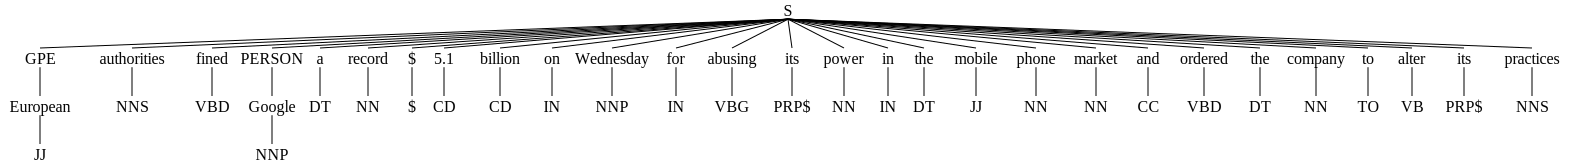

In [23]:
ne_tree = ne_chunk(pos_tag(word_tokenize(sentence)))
ne_tree

In [24]:
def preprocess(sent):
    sent = nltk.word_tokenize(sent)
    sent = nltk.pos_tag(sent)
    return sent

In [25]:
sent = preprocess(sentence)
sent

[('European', 'JJ'),
 ('authorities', 'NNS'),
 ('fined', 'VBD'),
 ('Google', 'NNP'),
 ('a', 'DT'),
 ('record', 'NN'),
 ('$', '$'),
 ('5.1', 'CD'),
 ('billion', 'CD'),
 ('on', 'IN'),
 ('Wednesday', 'NNP'),
 ('for', 'IN'),
 ('abusing', 'VBG'),
 ('its', 'PRP$'),
 ('power', 'NN'),
 ('in', 'IN'),
 ('the', 'DT'),
 ('mobile', 'JJ'),
 ('phone', 'NN'),
 ('market', 'NN'),
 ('and', 'CC'),
 ('ordered', 'VBD'),
 ('the', 'DT'),
 ('company', 'NN'),
 ('to', 'TO'),
 ('alter', 'VB'),
 ('its', 'PRP$'),
 ('practices', 'NNS')]

In [26]:
pattern = """ CHUNK: {<A>*<P>+} """
cp = nltk.RegexpParser(pattern)
cs = cp.parse(sent)
print(cs)

(S
  European/JJ
  authorities/NNS
  fined/VBD
  Google/NNP
  a/DT
  record/NN
  $/$
  5.1/CD
  billion/CD
  on/IN
  Wednesday/NNP
  for/IN
  abusing/VBG
  its/PRP$
  power/NN
  in/IN
  the/DT
  mobile/JJ
  phone/NN
  market/NN
  and/CC
  ordered/VBD
  the/DT
  company/NN
  to/TO
  alter/VB
  its/PRP$
  practices/NNS)


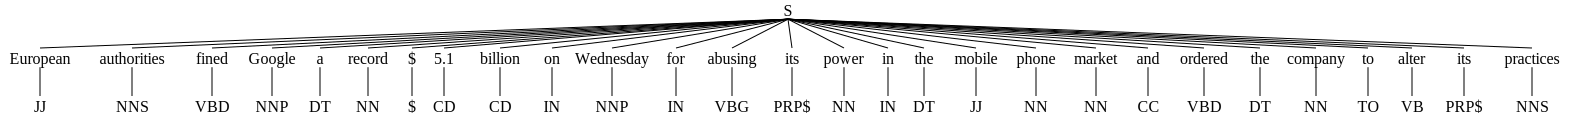

In [27]:
NPChunker = nltk.RegexpParser(pattern) 
result = NPChunker.parse(sent)
result

In [28]:
iob_tagged = tree2conlltags(cs)
pprint(iob_tagged)

[('European', 'JJ', 'O'),
 ('authorities', 'NNS', 'O'),
 ('fined', 'VBD', 'O'),
 ('Google', 'NNP', 'O'),
 ('a', 'DT', 'O'),
 ('record', 'NN', 'O'),
 ('$', '$', 'O'),
 ('5.1', 'CD', 'O'),
 ('billion', 'CD', 'O'),
 ('on', 'IN', 'O'),
 ('Wednesday', 'NNP', 'O'),
 ('for', 'IN', 'O'),
 ('abusing', 'VBG', 'O'),
 ('its', 'PRP$', 'O'),
 ('power', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('the', 'DT', 'O'),
 ('mobile', 'JJ', 'O'),
 ('phone', 'NN', 'O'),
 ('market', 'NN', 'O'),
 ('and', 'CC', 'O'),
 ('ordered', 'VBD', 'O'),
 ('the', 'DT', 'O'),
 ('company', 'NN', 'O'),
 ('to', 'TO', 'O'),
 ('alter', 'VB', 'O'),
 ('its', 'PRP$', 'O'),
 ('practices', 'NNS', 'O')]


In [29]:
# Import the SpaCy English model
try:
    nlp = spacy.load("en_core_web_lg")
except:
    nlp = spacy.load("en_core_web_sm")

In [30]:
doc = nlp(sentence)
pprint([(X.text, X.label_) for X in doc.ents])

[('European', 'NORP'),
 ('Google', 'ORG'),
 ('$5.1 billion', 'MONEY'),
 ('Wednesday', 'DATE')]


In [31]:
pprint([(X, X.ent_iob_, X.ent_type_) for X in doc])

[(European, 'B', 'NORP'),
 (authorities, 'O', ''),
 (fined, 'O', ''),
 (Google, 'B', 'ORG'),
 (a, 'O', ''),
 (record, 'O', ''),
 ($, 'B', 'MONEY'),
 (5.1, 'I', 'MONEY'),
 (billion, 'I', 'MONEY'),
 (on, 'O', ''),
 (Wednesday, 'B', 'DATE'),
 (for, 'O', ''),
 (abusing, 'O', ''),
 (its, 'O', ''),
 (power, 'O', ''),
 (in, 'O', ''),
 (the, 'O', ''),
 (mobile, 'O', ''),
 (phone, 'O', ''),
 (market, 'O', ''),
 (and, 'O', ''),
 (ordered, 'O', ''),
 (the, 'O', ''),
 (company, 'O', ''),
 (to, 'O', ''),
 (alter, 'O', ''),
 (its, 'O', ''),
 (practices, 'O', '')]


In [76]:
gma = gma_scrape('https://www.gmanetwork.com/news/topstories/nation/849165/deped-not-in-business-of-erasing-martial-law-facts-says-vp-sara/story/')
gma

,Title,Author,Date,Text
0,DepEd not in business of erasing Martial Law f...,None,2022-10-25,Vice President and Education Secretary Sara D...


In [77]:
article = nlp(gma['Text'].iloc[0])
len(article.ents)

51

In [78]:
labels = [x.label_ for x in article.ents]
Counter(labels)

Counter({'ORG': 22,
         'PERSON': 12,
         'DATE': 4,
         'GPE': 5,
         'WORK_OF_ART': 2,
         'LAW': 2,
         'CARDINAL': 4})

In [79]:
items = [x.text for x in article.ents]
Counter(items).most_common(5)

[('Martial Law', 5),
 ('DepEd', 4),
 ('Education', 2),
 ('Sara Duterte', 1),
 ('Tuesday', 1)]

In [84]:
sentences = [x for x in article.sents]
displacy.render(nlp(str(sentences[0])), jupyter=True, style='ent')

In [85]:
displacy.render(nlp(str(sentences[0])), style='dep', jupyter = True, options = {'distance': 120})


In [89]:
[(x.orth_,x.pos_, x.lemma_) for x in [y 
                                      for y
                                      in nlp(str(sentences[0])) 
                                      if not y.is_stop and y.pos_ != 'PUNCT' and not y.is_space]]

[('Vice', 'PROPN', 'Vice'),
 ('President', 'PROPN', 'President'),
 ('Education', 'PROPN', 'Education'),
 ('Secretary', 'PROPN', 'Secretary'),
 ('Sara', 'PROPN', 'Sara'),
 ('Duterte', 'PROPN', 'Duterte'),
 ('Tuesday', 'PROPN', 'Tuesday'),
 ('refuted', 'VERB', 'refute'),
 ('rebranding', 'ADJ', 'rebranding'),
 ('claims', 'NOUN', 'claim'),
 ('Martial', 'PROPN', 'Martial'),
 ('Law', 'PROPN', 'Law'),
 ('historical', 'ADJ', 'historical'),
 ('records', 'NOUN', 'record'),
 ('schools', 'NOUN', 'school'),
 ('saying', 'VERB', 'say'),
 ('Department', 'PROPN', 'Department'),
 ('Education', 'PROPN', 'Education'),
 ('DepEd', 'PROPN', 'DepEd'),
 ('business', 'NOUN', 'business'),
 ('erasing', 'VERB', 'erase'),
 ('facts', 'NOUN', 'fact')]

In [90]:
dict([(str(x), x.label_) for x in nlp(str(sentences[0])).ents])

{'Education': 'ORG',
 'Sara Duterte': 'PERSON',
 'Tuesday': 'DATE',
 'Martial Law': 'ORG',
 'the Department of Education (DepEd': 'ORG'}

In [95]:
pprint([(x, x.ent_iob_, x.ent_type_) for x in sentences[0]])

[( , 'O', ''),
 (Vice, 'O', ''),
 (President, 'O', ''),
 (and, 'O', ''),
 (Education, 'B', 'ORG'),
 (Secretary, 'O', ''),
 (Sara, 'B', 'PERSON'),
 (Duterte, 'I', 'PERSON'),
 (on, 'O', ''),
 (Tuesday, 'B', 'DATE'),
 (refuted, 'O', ''),
 (rebranding, 'O', ''),
 (claims, 'O', ''),
 (of, 'O', ''),
 (Martial, 'B', 'ORG'),
 (Law, 'I', 'ORG'),
 (historical, 'O', ''),
 (records, 'O', ''),
 (in, 'O', ''),
 (schools, 'O', ''),
 (,, 'O', ''),
 (saying, 'O', ''),
 (the, 'B', 'ORG'),
 (Department, 'I', 'ORG'),
 (of, 'I', 'ORG'),
 (Education, 'I', 'ORG'),
 ((, 'I', 'ORG'),
 (DepEd, 'I', 'ORG'),
 (), 'O', ''),
 (", 'O', ''),
 (is, 'O', ''),
 (not, 'O', ''),
 (in, 'O', ''),
 (the, 'O', ''),
 (business, 'O', ''),
 (of, 'O', ''),
 (erasing, 'O', ''),
 (these, 'O', ''),
 (facts, 'O', ''),
 (., 'O', '')]


In [96]:
displacy.render(article, jupyter=True, style='ent')
